In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
#from http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=30, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def get_df(file='temp.csv',field='field1',label='Temperature'):
    try:
        df_temp=pd.read_csv(file,parse_dates=["Time"]).set_index("Time")
        print("ok reading", file)
    except:
        print("downloading from thingspeak")
        import thingspeak
        ch = thingspeak.Channel(329109)
        temp=ch.get_field(field,{'results':8000})
        import json
        obj = json.loads(temp)
        df_temp0=pd.io.json.json_normalize(obj['feeds'])
        df_temp=pd.DataFrame()
        df_temp[label]=df_temp0[field].astype("float64")
        df_temp["Time"]=pd.to_datetime(df_temp0['created_at'])
        df_temp.set_index('Time',inplace=True)
        df_temp=df_temp[(df_temp.index>'2018-1-8')& (df_temp.index<'2018-1-23')]
        print("writing to ", file)
        df_temp.to_csv(file)
    return df_temp

In [4]:
df_temp=get_df(file='temp.csv',field='field1',label='Temperature')
df_hum=get_df(file='hum.csv',field='field2',label='Humidity')
df_pres=get_df(file='pres.csv',field='field3',label='Pressure')
df_wind=get_df(file='wind.csv',field='field8',label='Wind')

ok reading temp.csv
ok reading hum.csv
ok reading pres.csv
ok reading wind.csv


In [5]:
df_temp_10min=df_temp.resample('10T').median()
df_temp_15min=df_temp.resample('15T').median()
df_temp_20min=df_temp.resample('20T').median()
df_temp_30min=df_temp.resample('30T').median()
df_temp_60min=df_temp.resample('60T').median()
print((len(df_temp_10min)))
df_temp_10min["Temperature"].isnull().sum()

2066


0

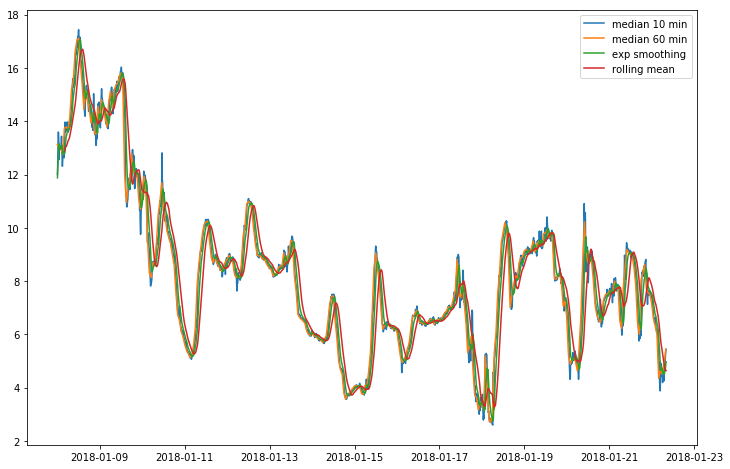

In [6]:
#exponential smoothing
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.plot(df_temp_10min, label='median 10 min')
plt.plot(df_temp_60min,label='median 60 min');
plt.plot(df_temp.ewm(adjust=True,alpha=0.1,ignore_na=False,min_periods=0).mean(), label='exp smoothing')
plt.plot(df_temp.rolling(center=False,window=50).mean(), label='rolling mean')
plt.legend();
#pd.stats.moments.ewma(df_temp,alpha=0.01).plot()

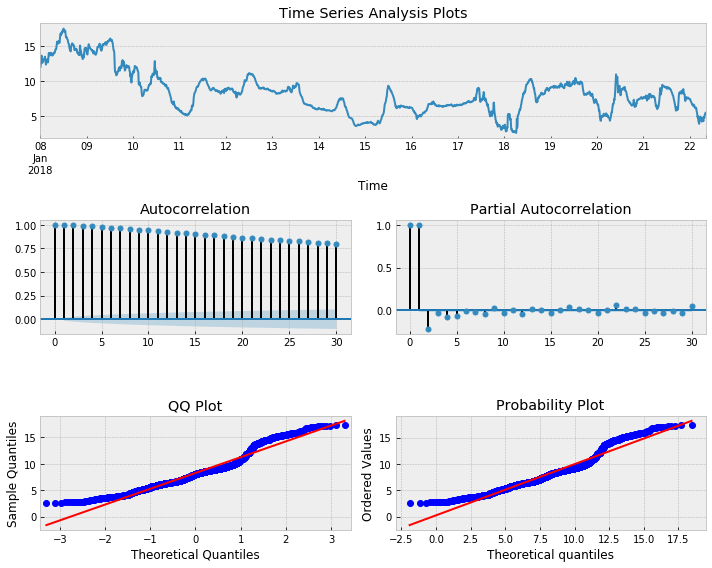

In [7]:
tsplot(df_temp_10min.Temperature)

## Seaonal-trend decomposition

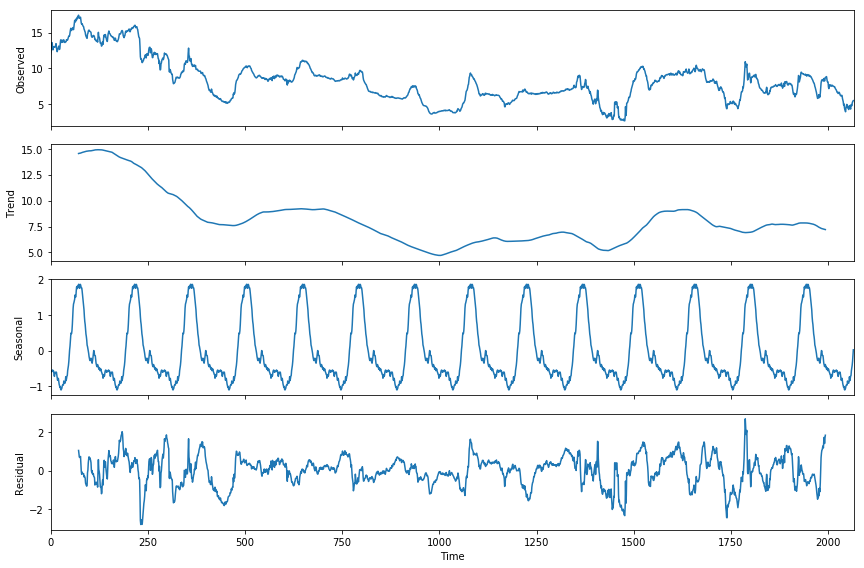

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tseries import seasonal_decompose
result_10min = seasonal_decompose(df_temp_10min.Temperature.values, model='additive',freq=24*6)
#result = seasonal_decompose(df_temp_10min, model='additive')
result_10min.plot();
result_60min = seasonal_decompose(df_temp_60min.Temperature.values, model='additive',freq=24)
#result = seasonal_decompose(df_temp_10min, model='additive')
#result_60min.plot();

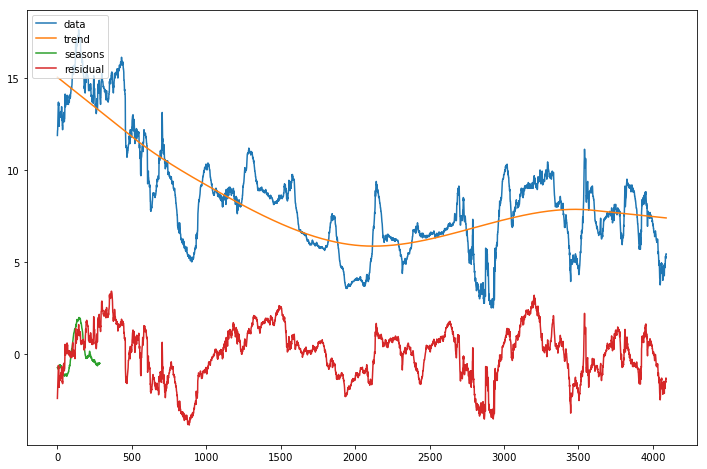

In [9]:
from seasonal import fit_seasons, adjust_seasons
seasons, trend = fit_seasons(df_temp.Temperature.values)
adjusted = adjust_seasons(df_temp.Temperature.values, seasons=seasons)
residual = adjusted - trend
plt.plot(df_temp.Temperature.values, label='data')
plt.plot(trend, label='trend')
plt.plot(seasons, label='seasons')
plt.plot(residual, label='residual')
plt.legend(loc='upper left')

### differentiation

In [10]:
#Delta_1
df_temp_diff=df_temp.diff().dropna()
df_temp_10min_diff=df_temp_10min.diff().dropna()
df_temp_15min_diff=df_temp_15min.diff().dropna()
df_temp_20min_diff=df_temp_20min.diff().dropna()
df_temp_30min_diff=df_temp_30min.diff().dropna()
df_temp_60min_diff=df_temp_60min.diff().dropna()
#Delta_1 Delta_24
df_temp_diff124=df_temp_diff.diff(24*12).dropna()
df_temp_10min_diff124=df_temp_10min_diff.diff(24*6).dropna()
df_temp_15min_diff124=df_temp_15min_diff.diff(24*4).dropna()
df_temp_20min_diff124=df_temp_20min_diff.diff(24*3).dropna()
df_temp_30min_diff124=df_temp_30min_diff.diff(24*2).dropna()
df_temp_60min_diff124=df_temp_60min_diff.diff(24*1).dropna()
#Delta_24
df_temp_diff24=df_temp.diff(24*12).dropna()
df_temp_10min_diff24=df_temp_10min.diff(24*6).dropna()
df_temp_15min_diff24=df_temp_15min.diff(24*4).dropna()
df_temp_20min_diff24=df_temp_20min.diff(24*3).dropna()
df_temp_30min_diff24=df_temp_30min.diff(24*2).dropna()
df_temp_60min_diff24=df_temp_60min.diff(24*1).dropna()

In [11]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(df_temp_10min.Temperature)[1])
print(adfuller(df_temp_10min_diff.Temperature)[1])
print(adfuller(df_temp_10min_diff24.Temperature)[1])
print(adfuller(df_temp_10min_diff124.Temperature)[1])

0.0473744060476
1.47664458846e-14
0.0158624412709
1.92571028251e-19


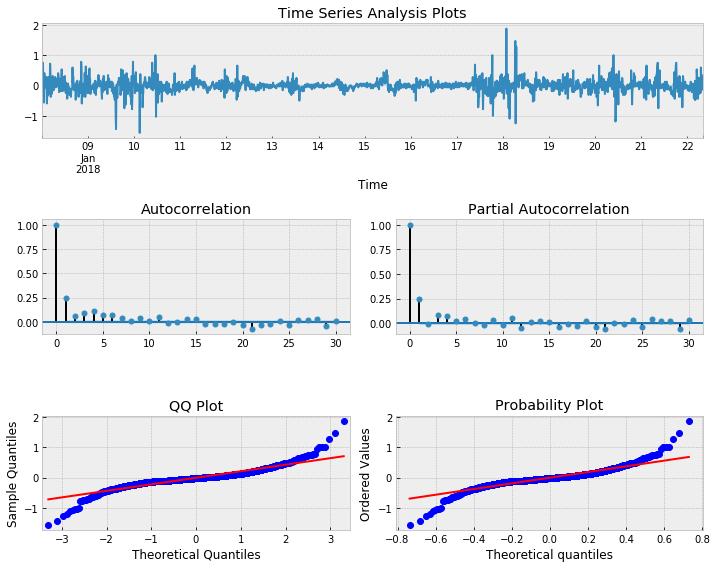

In [12]:
tsplot(df_temp_10min_diff.Temperature)

## ACF

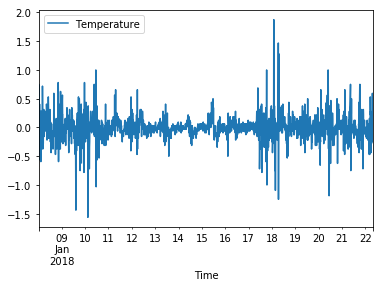

In [13]:
%matplotlib inline
df_temp_10min_diff.plot();

### plots

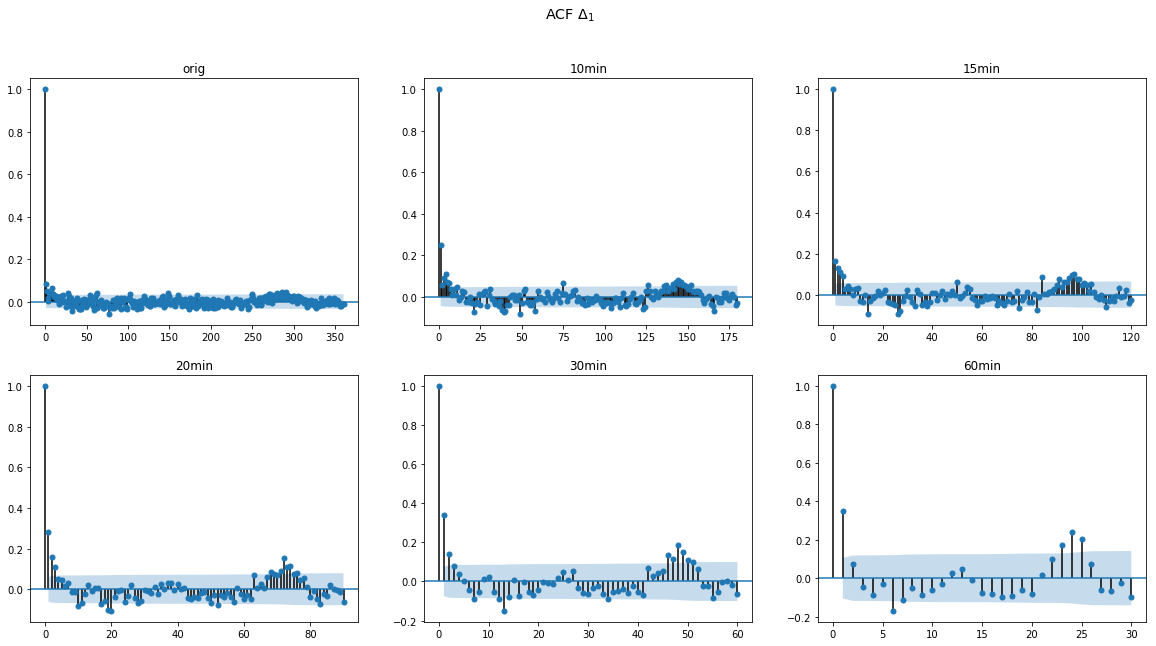

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f, ax = plt.subplots(2,3,figsize=(20,10))
plot_acf(df_temp_diff,lags=360,ax=ax[0,0],title='orig');
plot_acf(df_temp_10min_diff,lags=180,ax=ax[0,1],title='10min');
plot_acf(df_temp_15min_diff,lags=120,ax=ax[0,2],title='15min');
plot_acf(df_temp_20min_diff,lags=90,ax=ax[1,0],title='20min');
plot_acf(df_temp_30min_diff,lags=60,ax=ax[1,1],title='30min');
plot_acf(df_temp_60min_diff,lags=30,ax=ax[1,2],title='60min');
f.suptitle("ACF $\Delta_1$", fontsize="x-large");

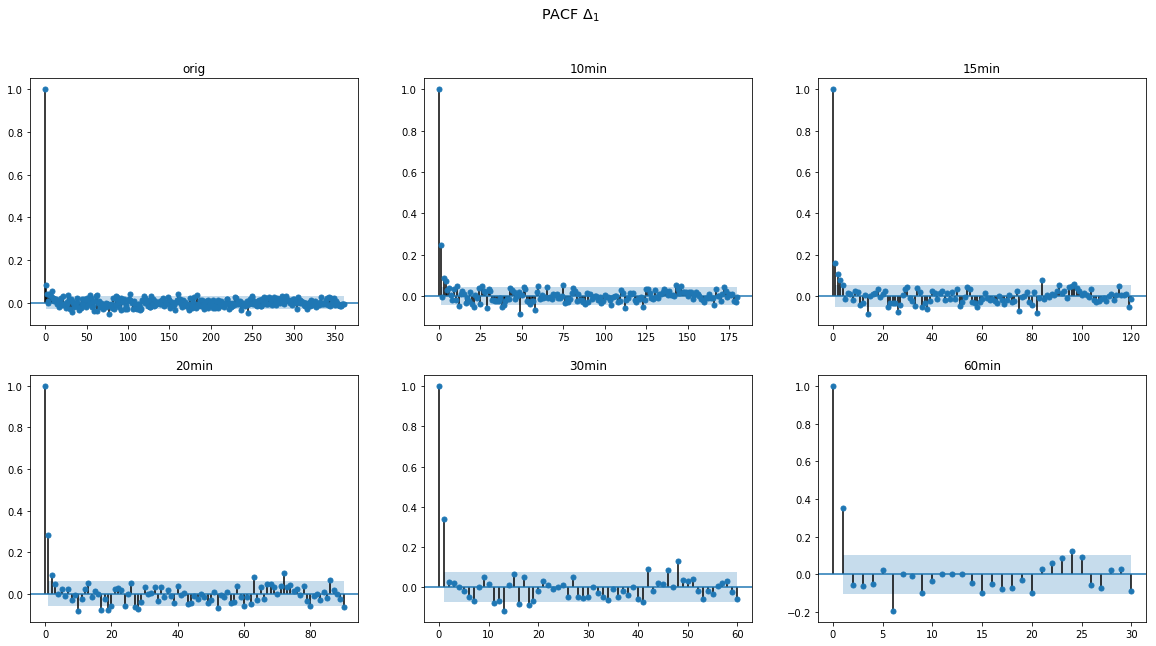

In [15]:
f, ax = plt.subplots(2,3,figsize=(20,10))
plot_pacf(df_temp_diff,lags=360,ax=ax[0,0],title='orig');
plot_pacf(df_temp_10min_diff,lags=180,ax=ax[0,1],title='10min');
plot_pacf(df_temp_15min_diff,lags=120,ax=ax[0,2],title='15min');
plot_pacf(df_temp_20min_diff,lags=90,ax=ax[1,0],title='20min');
plot_pacf(df_temp_30min_diff,lags=60,ax=ax[1,1],title='30min');
plot_pacf(df_temp_60min_diff,lags=30,ax=ax[1,2],title='60min');
f.suptitle("PACF $\Delta_1$", fontsize="x-large");

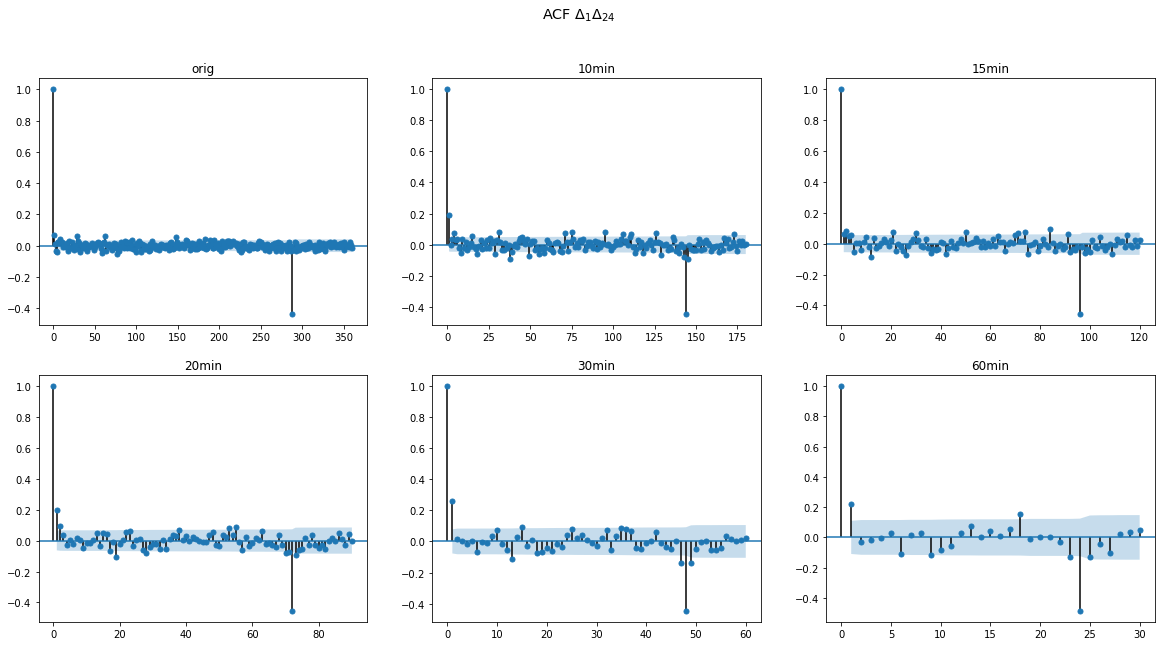

In [16]:
f, ax = plt.subplots(2,3,figsize=(20,10))
plot_acf(df_temp_diff124,lags=360,ax=ax[0,0],title='orig');
plot_acf(df_temp_10min_diff124,lags=180,ax=ax[0,1],title='10min');
plot_acf(df_temp_15min_diff124,lags=120,ax=ax[0,2],title='15min');
plot_acf(df_temp_20min_diff124,lags=90,ax=ax[1,0],title='20min');
plot_acf(df_temp_30min_diff124,lags=60,ax=ax[1,1],title='30min');
plot_acf(df_temp_60min_diff124,lags=30,ax=ax[1,2],title='60min');
f.suptitle("ACF $\Delta_1\Delta_{24}$", fontsize="x-large");

### spectrum

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 2048 is greater than input length  = 1377, using nperseg = 1377
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 2048 is greater than input length  = 1033, using nperseg = 1033
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 2048 is greater than input length  = 689, using nperseg = 689
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 2048 is greater than input length  = 345, using nperseg = 345
  .format(nperseg, input_length))


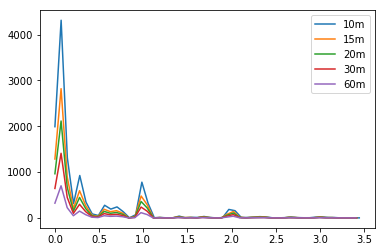

In [17]:
from scipy.signal import welch
f10,P10= welch(df_temp_10min.Temperature,nperseg=2048)
f15,P15= welch(df_temp_15min.Temperature,nperseg=2048)
f20,P20= welch(df_temp_20min.Temperature,nperseg=2048)
f30,P30= welch(df_temp_30min.Temperature,nperseg=2048)
f60,P60= welch(df_temp_60min.Temperature,nperseg=2048)
plt.plot(f10[:50]*6*24,P10[:50],label='10m')
plt.plot(f15[:50]*4*24,P15[:50],label='15m')
plt.plot(f20[:50]*3*24,P20[:50],label='20m')
plt.plot(f30[:50]*2*24,P30[:50],label='30m')
plt.plot(f60[:50]*1*24,P60[:50],label='60m')
plt.legend();

In [18]:
#f, ax = plt.subplots(2,3,figsize=(20,10))
#plot_acf(df_temp_diff24,lags=360,ax=ax[0,0],title='orig');
#plot_acf(df_temp_10min_diff24,lags=180,ax=ax[0,1],title='10min');
#plot_acf(df_temp_15min_diff24,lags=120,ax=ax[0,2],title='15min');
#plot_acf(df_temp_20min_diff24,lags=90,ax=ax[1,0],title='20min');
#plot_acf(df_temp_30min_diff24,lags=60,ax=ax[1,1],title='30min');
#plot_acf(df_temp_60min_diff24,lags=30,ax=ax[1,2],title='60min');
#f.suptitle("ACF $\Delta_{24}$", fontsize="x-large");

## ARIMA

In [19]:
# fitting a stepwise model:
from pyramid.arima import auto_arima, ARIMA

stepwise_fit = auto_arima(df_temp_60min, start_p=0, start_q=0, max_p=3, max_q=3, m=24,
                          start_P=0,start_Q=0 ,seasonal=True, max_d=2, max_D=2, max_P=3,max_Q=3, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=604.062, BIC=619.436, Fit time=1.256 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=607.343, BIC=622.717, Fit time=1.157 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=612.234, BIC=623.765, Fit time=0.292 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=596.500, BIC=615.718, Fit time=6.931 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=578.619, BIC=601.680, Fit time=15.553 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 0, 2, 24); AIC=580.488, BIC=611.236, Fit time=87.797 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=591.376, BIC=610.594, Fit time=10.936 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=577.292, BIC=604.197, Fit time=16.352 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 1, 

In [20]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  345
Model:             SARIMAX(3, 1, 0)x(2, 0, 1, 24)   Log Likelihood                -280.419
Date:                            Sun, 04 Feb 2018   AIC                            576.838
Time:                                    17:22:07   BIC                            607.587
Sample:                                         0   HQIC                           589.084
                                            - 345                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.009      0.022      0.982      -0.018       0.018
ar.L1          0.2174      0.049      4.410      0.000       0.121       0.314
ar.L2         -0.0818      0.052     -1.581      0.114      -0.183       0.020
ar.L3         -0.0856      0.059     -1.456      0.145      -0.201       0.030
ar.S.L24       0.8047      0.119      6.761      0.000       0.571       1.038
ar.S.L48       0.1365      0.089      1.540      0.124      -0.037       0.310
ma.S.L24      -0.7567      0.105     -7.194      0.000      -0.963      -0.551
sigma2         0.2868      0.015     19.152      0.000       0.257       0.316
===================================================================================
Ljung-Box (Q):                       33.22   Jarque-Bera (JB):               236.24
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.29
Prob(H) (two-sided):                  0.18   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from pyramid.arima import auto_arima, ARIMA
fit_110_101 = ARIMA((1,1,0),(1,0,1,24)).fit(df_temp_60min)
fit_110_101.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  345
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 24)   Log Likelihood                -284.387
Date:                            Sun, 04 Feb 2018   AIC                            578.775
Time:                                    17:22:13   BIC                            597.993
Sample:                                         0   HQIC                           586.428
                                            - 345                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.008     -0.033      0.974      -0.015       0.015
ar.L1          0.2178      0.047      4.607      0.000       0.125       0.310
ar.S.L24       0.9537      0.038     24.983      0.000       0.879       1.028
ma.S.L24      -0.8212      0.086     -9.524      0.000      -0.990      -0.652
sigma2         0.2961      0.015     19.766      0.000       0.267       0.325
===================================================================================
Ljung-Box (Q):                       39.53   Jarque-Bera (JB):               264.39
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -0.30
Prob(H) (two-sided):                  0.14   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

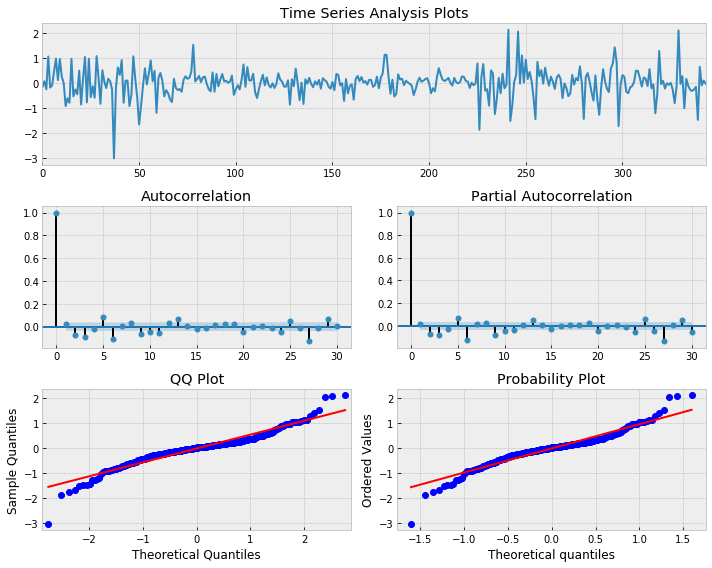

In [22]:
tsplot(fit_110_101.resid()[1:])

In [23]:
from bokeh.plotting import figure, show, output_notebook
import pandas as pd
import numpy as np

# init bokeh
output_notebook()

def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth = pd.Series(truth, index=np.arange(truth.shape[0]))
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=400, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth.index, truth.values, color=c1, legend='Observed')
    p.line(forecasts.index, forecasts.values, color=c2, legend='Forecasted')
    
    return p

Loading BokehJS ...

In [24]:
in_sample_preds = stepwise_fit.predict_in_sample()
in_sample_preds[:10]
show(plot_arima(df_temp_60min.Temperature.values, in_sample_preds, 
                title="Original Series & In-sample Predictions", 
                c2='#FF0000', forecast_start=0))

from  sklearn.metrics import mean_squared_error as mse

print("In sample MSE:")
mse(df_temp_60min.Temperature.values[5:],in_sample_preds[5:])

In sample MSE:


0.3034962977393712

In [25]:
print("In sample MSE:")
in_sample_preds = fit_110_101.predict_in_sample()
mse(df_temp_60min.Temperature.values[5:],in_sample_preds[5:])

In sample MSE:


0.30839407536849467

## Holt-Winters

In [26]:
def predict_exp_smooth(series,alpha=0.1):
    """eq (5.3) chapfield"""
    prediction=np.zeros(len(series))
    for i in range(0,len(series)-1):
        prediction[i+1]=alpha*series[i]+(1-alpha)*prediction[i]
    return prediction

def error_method(params, series, method,*args):
    from  sklearn.metrics import mean_squared_error as mse
    result=method(series, params,*args)
    length=min(len(series), len(result))-5
    return (mse(series[-length:], result[-length:]))

#def error_pes(alpha,series):
#    return error_method(alpha, series, predict_exp_smooth)
   # return (mse(series,predict_exp_smooth(series,alpha)))

    
def constraint1(x):
    return x
def constraint2(x):
    return 1-x
def constraint1a(x):
    return x[0]
def constraint2a(x):
    return 1-x[0]
def constraint1b(x):
    return x[1]
def constraint2b(x):
    return 1-x[1]
def constraint1c(x):
    return x[2]
def constraint2c(x):
    return 1-x[2]


from scipy.optimize import minimize
print(minimize(error_method,x0=0.5, args=(df_temp_60min.Temperature.values,predict_exp_smooth),method='COBYLA', # # COBYLA and SLSQP
      constraints=({'type': 'ineq', 'fun': constraint1},{'type': 'ineq', 'fun': constraint2})))

     fun: 0.39076861213235292
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 7
  status: 1
 success: True
       x: array(1.0)


In [27]:
%load_ext autoreload
%autoreload 2
import holt_winters as hw
#from holt_winters import exponential_smoothing, double_exponential_smoothing, triple_exponential_smoothing

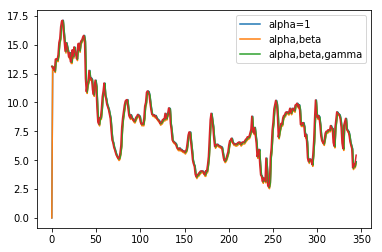

In [28]:
%matplotlib inline
plt.plot(hw.exponential_smoothing(df_temp_60min.Temperature.values,1),label="alpha=1")
plt.plot(hw.double_exponential_smoothing(df_temp_60min.Temperature.values,(1,0.00)),label='alpha,beta')
plt.plot(hw.triple_exponential_smoothing(df_temp_60min.Temperature.values,(1,0.00,0.),24,0),label='alpha,beta,gamma')
plt.plot(df_temp_60min.Temperature.values)
plt.legend();

In [29]:
print(minimize(error_method,x0=0.5, args=(df_temp_60min.Temperature.values,hw.exponential_smoothing),method='COBYLA', # # COBYLA and SLSQP
      constraints=({'type': 'ineq', 'fun': constraint1},{'type': 'ineq', 'fun': constraint2})))

     fun: 0.39076861213235292
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 7
  status: 1
 success: True
       x: array(1.0)


In [30]:
print(minimize(error_method,x0=(0.1,0.1), args=(df_temp_60min.Temperature.values,hw.double_exponential_smoothing),method='COBYLA', # # COBYLA and SLSQP
    constraints=({'type': 'ineq', 'fun': constraint1a},
                 {'type': 'ineq', 'fun': constraint2a},
                 {'type': 'ineq', 'fun': constraint1b},
                 {'type': 'ineq', 'fun': constraint2b}
                )))
#print(minimize(error_method,x0=(0.5,0.5), args=(df_temp_60min.Temperature.values,hw.double_exponential_smoothing),method='COBYLA')), # # COBYLA and SLSQP))

     fun: 0.39510648987134167
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 34
  status: 1
 success: True
       x: array([ 1.        ,  0.00901753])


In [31]:
print(minimize(error_method,x0=(0.5,0.5,0.5), args=(df_temp_60min.Temperature.values,hw.triple_exponential_smoothing, 24, 0),method='COBYLA', # # COBYLA and SLSQP
    constraints=({'type': 'ineq', 'fun': constraint1a},
                 {'type': 'ineq', 'fun': constraint2a},
                 {'type': 'ineq', 'fun': constraint1b},
                 {'type': 'ineq', 'fun': constraint2b},                 
                 {'type': 'ineq', 'fun': constraint1c},
                 {'type': 'ineq', 'fun': constraint2c}
                )))

     fun: 0.39044176668210051
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 47
  status: 1
 success: True
       x: array([ 1.        ,  0.        ,  0.83604241])


Does not do any better than predicting the previous value

## Autoregression

In [32]:
def series_to_df(series,n_shifts):
    cols=[]
    for i in n_shifts:
        cols.append("d"+str(i))
    dataframe=pd.DataFrame(columns=cols)
    for i in n_shifts:
        dataframe["d"+str(i)]=series.shift(i)
    return dataframe.dropna(how="any")

In [33]:
#linear regression via statsmodels.formula.api, R style
import statsmodels.formula.api as smf
df_Temp=series_to_df(df_temp_60min.Temperature,(23,24,25,3,2,1,0))
#'here I add sin and cos of hour, as described below
#df_Temp["hour"]=sin(df_Temp.index.hour*2*pi/24)
#df_Temp["hour2"]=cos(df_Temp.index.hour*2*pi/24)
#df_Temp["hour3"]=sin(df_Temp.index.hour*4*pi/24)
#df_Temp["hour4"]=cos(df_Temp.index.hour*4*pi/24)
#frac=0.5
#df_Temp_train=df_Temp.ix[:int(frac*X.shape[0]),:]
#df_Temp_test=df_Temp.ix[int(frac*X.shape[0]):,:]
df_Temp_train=df_Temp

result = smf.ols("d0 ~ d1+d2+d23+d24+d25",df_Temp_train).fit()
print(result.summary())
print(result.params)
predict_train=result.predict(df_Temp_train)
#predict_test=result.predict(df_Temp_test)
print("train error:",mse(predict_train,df_Temp_train.d0))
#print("test error:",error_predict(predict_test,df_Temp_test.d0))
print(result.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                     d0   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1224.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):          1.61e-203
Time:                        17:22:29   Log-Likelihood:                -262.52
No. Observations:                 320   AIC:                             537.0
Df Residuals:                     314   BIC:                             559.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2895      0.107      2.709      0.0

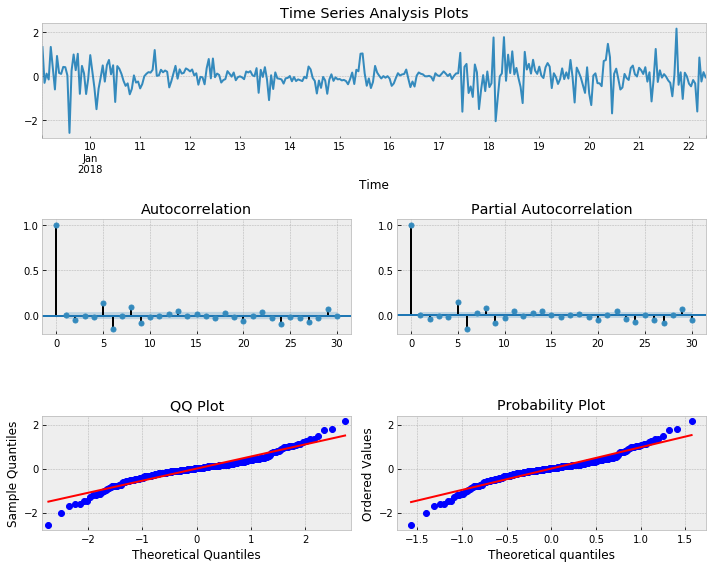

In [34]:
tsplot(result.resid)

Results similar to ARIMA

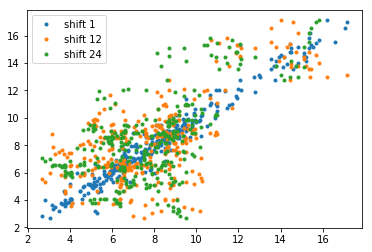

In [35]:
%matplotlib inline
plt.plot(df_temp_60min,df_temp_60min.shift(1),'.',label='shift 1')
plt.plot(df_temp_60min,df_temp_60min.shift(12),'.',label='shift 12')
plt.plot(df_temp_60min,df_temp_60min.shift(24),'.',label='shift 24')
plt.legend();

In [36]:
#%%R -i df_temp
#ets(df_temp)

## GARCH

In [37]:
arch.arch_model?

Object `arch.arch_model` not found.


In [38]:
from arch import arch_model
import arch

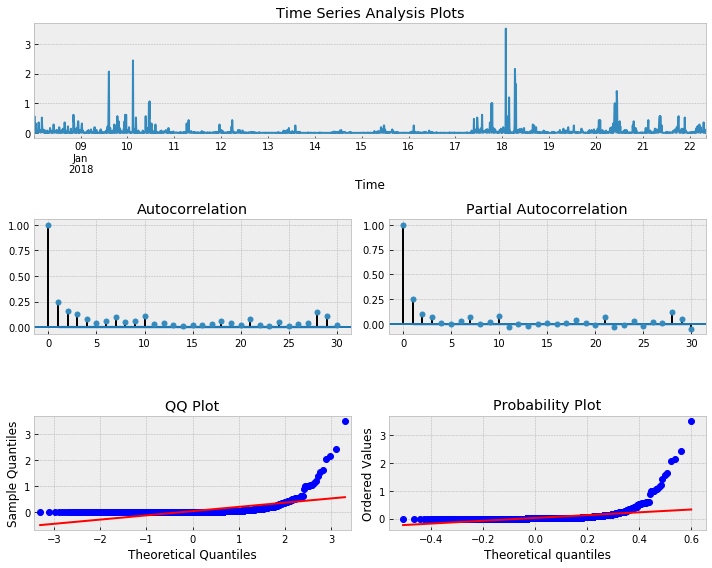

In [39]:
tsplot(df_temp_10min_diff.Temperature**2)

In [50]:
am = arch_model(df_temp_10min_diff, p=1, o=0, q=1, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  Temperature   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                955.612
Distribution:      Standardized Student's t   AIC:                          -1901.22
Method:                  Maximum Likelihood   BIC:                          -1873.06
                                              No. Observations:                 2065
Date:                      Sun, Feb 04 2018   Df Residuals:                     2060
Time:                              22:02:58   Df Model:                            5
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

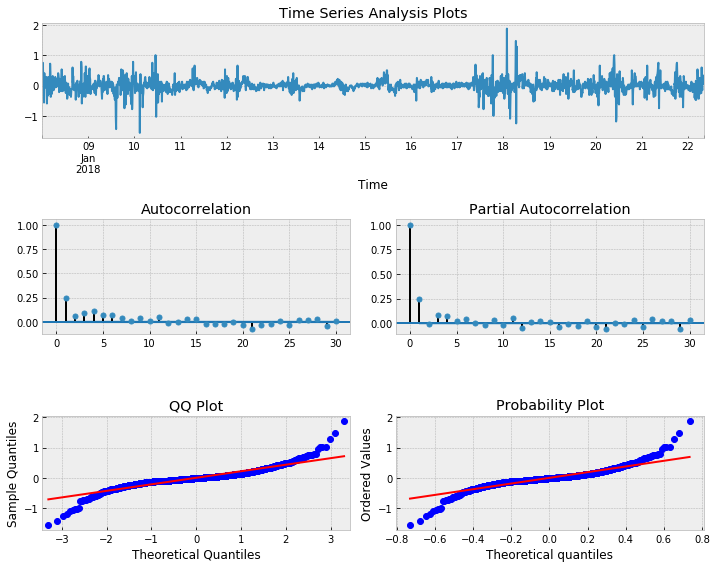

In [49]:
tsplot(res.resid)

In [54]:
#residuals from arima 110_101
am = arch_model(fit_110_101.resid()[1:], p=10, o=10, q=10, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.003
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                        GJR-GARCH   Log-Likelihood:               -218.619
Distribution:      Standardized Student's t   AIC:                           503.238
Method:                  Maximum Likelihood   BIC:                           629.979
                                              No. Observations:                  344
Date:                      Sun, Feb 04 2018   Df Residuals:                      311
Time:                              22:31:20   Df Model:                           33
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

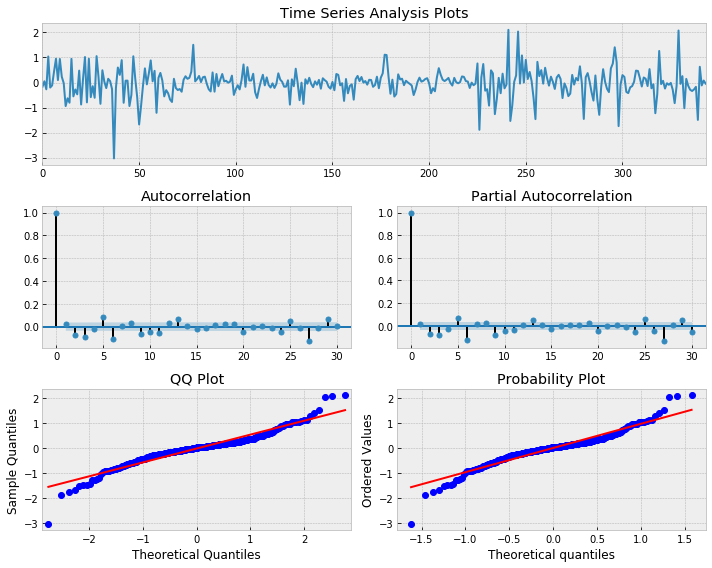

In [52]:
tsplot(res.resid)

try boxcox transformation

## Multivariate case

In [42]:
df_hum_10min=df_hum.resample('10T').median()
df_hum_15min=df_hum.resample('15T').median()
df_hum_20min=df_hum.resample('20T').median()
df_hum_30min=df_hum.resample('30T').median()
df_hum_60min=df_hum.resample('60T').median()
df_pres_10min=df_pres.resample('10T').median()
df_pres_15min=df_pres.resample('15T').median()
df_pres_20min=df_pres.resample('20T').median()
df_pres_30min=df_pres.resample('30T').median()
df_pres_60min=df_pres.resample('60T').median()
df_wind_10min=df_wind.resample('10T').median()
df_wind_15min=df_wind.resample('15T').median()
df_wind_20min=df_wind.resample('20T').median()
df_wind_30min=df_wind.resample('30T').median()
df_wind_60min=df_wind.resample('60T').median()

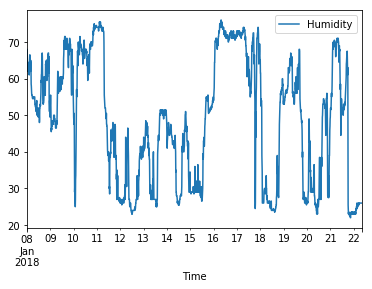

In [43]:
df_hum_10min.plot()

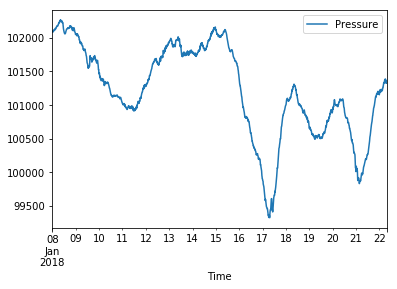

In [44]:
df_pres_10min.plot()

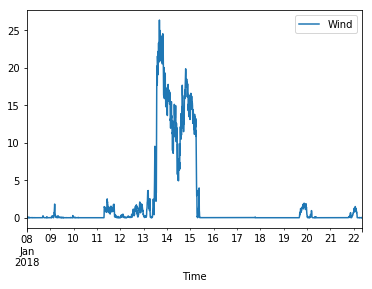

In [45]:
df_wind_10min.plot()

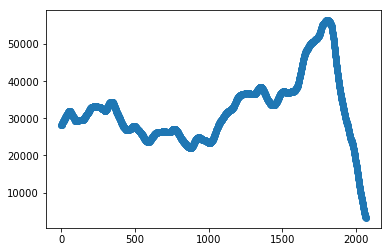

In [46]:
from scipy.signal import correlate
plt.plot(correlate(df_wind_10min,df_temp_10min, mode='same'),'o')

### VARMA